# Convolutional neural networks
---

![Conv net](https://miro.medium.com/max/1200/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

The fundamental difference between a densely connected layer and a convolution
layer is this: Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels), whereas convolution layers learn local patterns—in the case of images, patterns found in small 2D windows of the inputs.

![local features](https://media.geeksforgeeks.org/wp-content/uploads/20211129095034/Importantfeaturesoftheimage.png)

This key characteristic gives convnets two interesting properties:

- The patterns they learn are **translation-invariant**. After learning a certain pattern in the lower-right corner of a picture, a convnet can recognize it anywhere: for example, in the upper-left corner. A densely connected model would have to learn the pattern anew if it appeared at a new location. This makes convnets data-efficient when processing images (because the visual world is fundamentally translation-invariant): they need fewer training samples to learn representations that have generalization power.
- They can learn **spatial hierarchies of patterns**. A first convolution layer will learn small local patterns such as edges, a second convolution layer will learn larger patterns made of the features of the first layers, and so on. This allows convnets to efficiently learn increasingly complex and abstract visual concepts, because the visual world is fundamentally spatially hierarchical.

![Spatial hierarchies](https://i.ytimg.com/vi/rrOgPiqYu6s/hqdefault.jpg)


### MNIST Classification using Convolutional Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical

# this module has the mnist data set
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)


For reference, here is the model using dense layers and a vectorized input.

In [ ]:
# Normalizing input images, and one-hot-enconding labels
train_images_standard = train_images.reshape((60000, 28*28))
train_images_standard = train_images_standard.astype('float32') / 255

test_images_standard = test_images.reshape((10000, 28*28))
test_images_standard  = test_images_standard.astype('float32') / 255

train_labels_standard = to_categorical(train_labels)
test_labels_standard = to_categorical(test_labels)

# Model definition
model = models.Sequential([
  layers.Dense(16, activation='relu', input_shape=(784,)),
  layers.Dense(8, activation='relu'),
  layers.Dense(4, activation='relu'),
  layers.Dense(10, activation='softmax')
])

model.compile(optimizer=optimizers.SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                12560     
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 10)                50        
                                                                 
Total params: 12,782
Trainable params: 12,782
Non-trainable params: 0
_________________________________________________________________


313/313 [==============================] - 1s 3ms/step - loss: 0.2833 - accuracy: 0.9257
[0.2833084762096405, 0.9257000088691711]


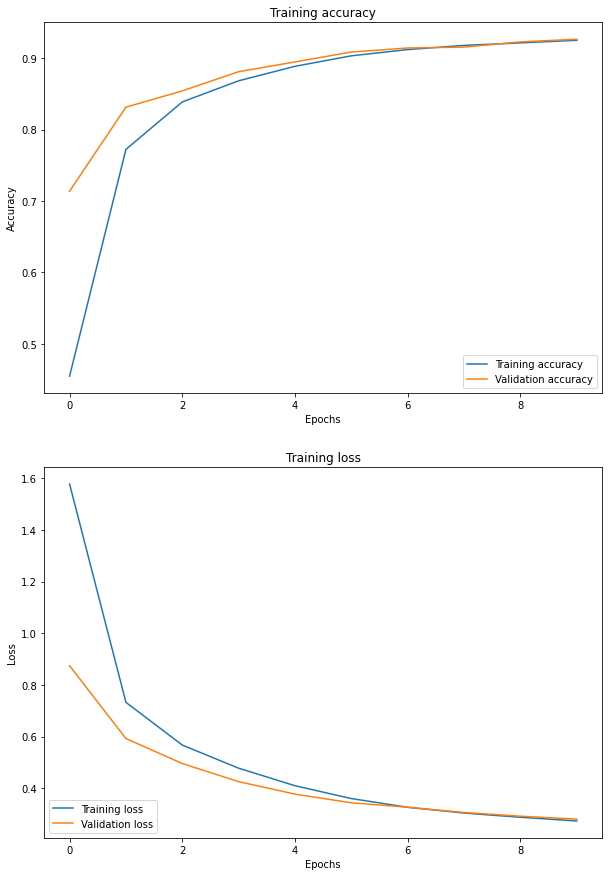

In [ ]:
# Training
history = model.fit(train_images_standard, train_labels_standard, epochs=10, validation_split=0.2, verbose=False)

# Evaluation
test_results = model.evaluate(test_images_standard, test_labels_standard)
print(test_results)

# Plotting results
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

fig, (ax_acc, ax_val) = plt.subplots(2, 1, figsize=(10, 15))
ax_acc.set_xlabel('Epochs')
ax_acc.set_ylabel('Accuracy')
ax_acc.plot(acc_values, label="Training accuracy")
ax_acc.plot(val_acc_values, label="Validation accuracy")
ax_acc.set_title("Training accuracy")
ax_acc.legend(loc='lower right')

ax_val.set_xlabel('Epochs')
ax_val.set_ylabel('Loss')
ax_val.plot(loss_values, label="Training loss")
ax_val.plot(val_loss_values, label="Validation loss")
ax_val.set_title("Training loss")
ax_val.legend(loc='lower left')


### Convolution basics

Convolutions operate over tensors called feature maps, with two spatial axes (height and width) as well as a depth axis (also called the channels axis). For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray).

Since convolutional layers can recieve matrices as input, we can leave the input images' shape as is, and just perform normalization of its values.

In [ ]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an output feature map. This output feature map is still tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a parameter of the layer, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. Filters encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance.

Convolutions are defined by two key parameters:
- Size of the patches extracted from the inputs: These are typically 3 × 3 or 5 × 5. 
- Depth of the output feature map: This is the number of filters computed by the convolution. 

In Keras Conv2D layers, these parameters are the first arguments passed to the layer:

Conv2D(output_depth, (window_height, window_width)).

A convolution works by sliding these windows of size 3 × 3 or 5 × 5 over the
input feature map, stopping at every possible location, and extracting the patch of surrounding features. 

![Strides](https://d2l.ai/_images/conv-pad.svg)

#### Padding

Padding consists of adding an appropriate number of rows and columns on each side of the input feature map so as to make it possible to fit center convolution windows around every input tile. In Conv2D layers, padding is configurable via the padding argument, which takes two values: "valid", which means no padding (only valid window locations will be used), and "same", which means "pad in such a way as to have an output with the same width and height as the input.” The padding argument defaults to "valid".

![Padding](https://programmathically.com/wp-content/uploads/2021/12/Screenshot-2021-12-03-at-10.33.11-1024x774.png)

#### Strides

The other factor that can influence output size is the notion of strides. Our description of convolution so far has assumed that the center tiles of the convolution windows are all contiguous. But the distance between two successive windows is a parameter of the convolution, called its stride, which defaults to 1. It’s possible to have strided convolutions: convolutions with a stride higher than 1. Using stride 2 means the width and height of the feature map are downsampled by a factor of 2 (in addition to any changes induced by border effects). Strided convolutions are rarely used in classification models.

#### Max-pooling

Max pooling consists of extracting windows from the input feature maps and
outputting the max value of each channel. It’s conceptually similar to convolution, except that instead of transforming local patches via a learned linear transformation (the convolution kernel), they’re transformed via a hardcoded max tensor operation. A big difference from convolution is that max pooling is usually done with 2 × 2 windows and stride 2, in order to downsample the feature maps by a factor of 2. 




### Putting it all together

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))

model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

model.compile(optimizers.RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1568)              0         
                                                                 
 dense_8 (Dense)             (None, 32)               

In [ ]:
checkpoint = ModelCheckpoint(filepath="mnist_weights.hdf5", verbose=1, save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint, earlyStop])

Epoch 1/30
1493/1500 [============================>.] - ETA: 0s - loss: 0.4747 - accuracy: 0.8297
Epoch 1: val_loss improved from inf to 0.34652, saving model to mnist_weights.hdf5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4744 - accuracy: 0.8299 - val_loss: 0.3465 - val_accuracy: 0.8726
Epoch 2/30
1491/1500 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8931
Epoch 2: val_loss improved from 0.34652 to 0.28344, saving model to mnist_weights.hdf5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3009 - accuracy: 0.8929 - val_loss: 0.2834 - val_accuracy: 0.8970
Epoch 3/30
1497/1500 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9056
Epoch 3: val_loss did not improve from 0.28344
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2595 - accuracy: 0.9056 - val_loss: 0.2932 - val_accuracy: 0.8941
Epoch 4/30
1495/1500 [============================>.] - ETA: 0s - loss: 0.2351 - accuracy:

#### Validation and predictions on new data

In [ ]:
test_results = model.evaluate(test_images, test_labels)
print(test_results)

313/313 [==============================] - 1s 3ms/step - loss: 0.2833 - accuracy: 0.9072
[0.28333041071891785, 0.9071999788284302]


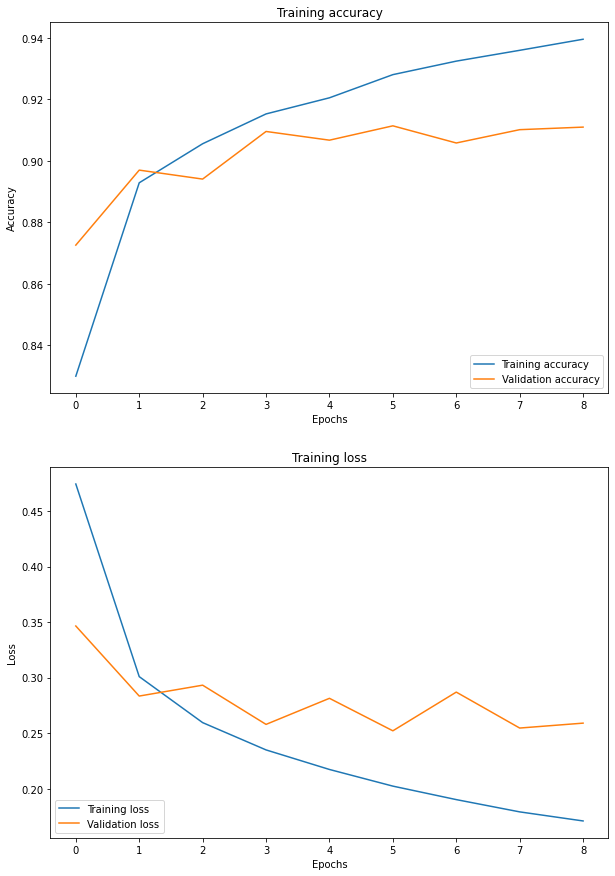

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

fig, ax = plt.subplots(2, 1, figsize=(10, 15))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].plot(acc_values, label="Training accuracy")
ax[0].plot(val_acc_values, label="Validation accuracy")
ax[0].set_title("Training accuracy")
ax[0].legend(loc='lower right')

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].plot(loss_values, label="Training loss")
ax[1].plot(val_loss_values, label="Validation loss")
ax[1].set_title("Training loss")
ax[1].legend(loc='lower left')

Prediction: 9 Label: 9


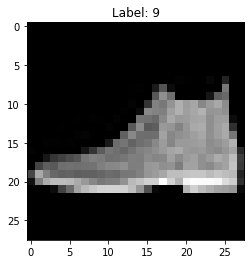

In [ ]:
test_index = 0

input_image = test_images[test_index].reshape((1, 28, 28, 1))

prediction = model.predict(input_image)

np.set_printoptions(precision=3, suppress= True)
print(f"Prediction: {np.argmax(prediction)} Label: {np.argmax(test_labels[test_index])}")

plt.title(f"Label: {np.argmax(test_labels[test_index])}")
plt.imshow(test_images[test_index].reshape(28,28), cmap='gray')

### Visualizing what the Conv Net learned

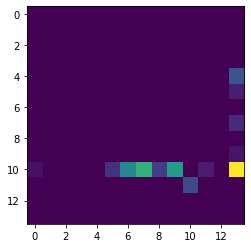

In [ ]:
test_index = 0

input_image = test_images[test_index].reshape((1, 28, 28, 1))

layer_outputs = [layer.output for layer in model.layers]

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(input_image)

plt.imshow(activations[1][0, :, :, 2])

(1, 28, 28, 64)
(1, 14, 14, 64)
(1, 14, 14, 32)
(1, 7, 7, 32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


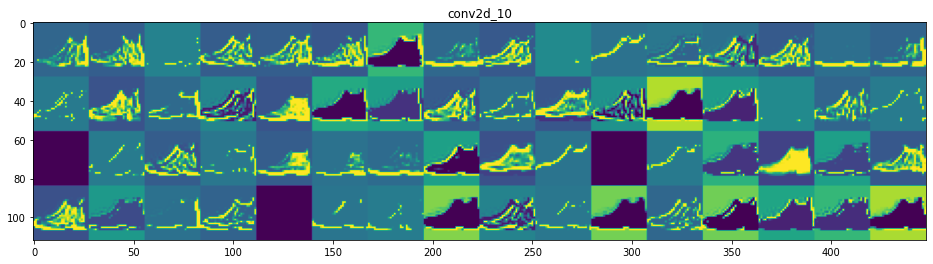

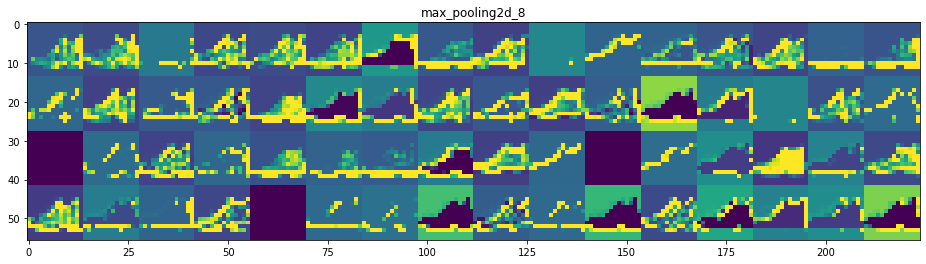

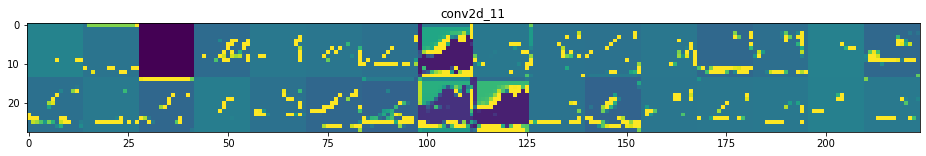

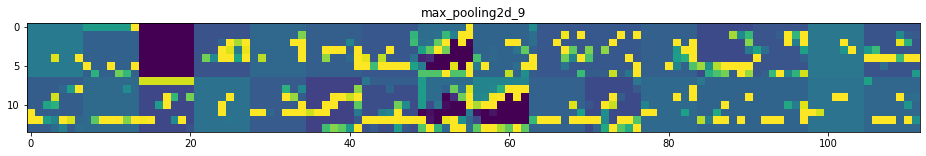

In [ ]:
images_per_row = 16

layer_names = [layer.name for layer in model.layers[:4]]

for layer_name, layer_activation in zip(layer_names, activations):
  
  print(layer_activation.shape)
  n_features = layer_activation.shape[-1]
  
  size = layer_activation.shape[1]
  
  n_rows = n_features // images_per_row
  
  display_grid = np.zeros((size*n_rows, images_per_row*size))
  
  for col in range(n_rows):
    for row in range(images_per_row):
      
      image = layer_activation[0, :, :, col * images_per_row + row]
      
      # Standardize image to (-1, 1)
      image -= image.mean()
      image /= image.std()

      # Move the center of the image, and adjust the values
      image += 1
      image *= 128

      # Clip values so that exceeding floats are discarded
      image = np.clip(image, 0, 255).astype('uint8')
      
      display_grid[col*size : (col+1)*size, row*size : (row+1)*size] = image

  scale = 1. / size
  
  plt.figure(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
  plt.title(layer_name)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')